# Alpaca Trading Workbook

### Create Class

In [2]:
# data & API packages
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, TimeFrameUnit
import sqlite3
import pandas as pd
import time
import random
import ta
import numpy as np
from datetime import datetime, timedelta
#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

class AlpacaTradingBot:
    """

    This class can be used to scrape stock data from the Alpaca API, store it locally in a SQLite Database,
    add indicators & perform predective analytics.

    """
    def __init__(self, keys_file_path='alpaca_keys.txt', base_url='https://paper-api.alpaca.markets', database_path=r'D:\Scripts\alpaca\alpaca_algo_trading\alpaca_data.db'):
        with open(keys_file_path, 'r') as file:
            self.api_key = file.readline().strip()
            self.api_secret = file.readline().strip()
        self.base_url = base_url
        self.api = tradeapi.REST(self.api_key, self.api_secret, base_url=base_url)
        self.database_path = database_path
        self.api_call_count = 0

    def download_bar_data(self, stock, timeframe, start_date, end_date, pause=True):
        """
        
        This method will be used to scrape bar data from the Alpaca API. 
        Provide a ticker symbol, an interval, and a beginning and end date.

        """
        all_data = []

        current_date = start_date
        while current_date <= end_date:
            # Check if it's a weekend (Saturday or Sunday) & skip, if so
            # if  datetime.strptime(current_date, "%Y-%m-%d").weekday() >= 5:
            #     current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
            #     continue

            # Split the day into two segments: midnight to noon, and noon to end of day because the API can only return 1,000 data points a day
            segments = [
                (f"{current_date}T00:00:00Z", f"{current_date}T11:59:59Z"),
                (f"{current_date}T12:00:00Z", f"{current_date}T23:59:59Z")
            ]

            for start_time, end_time in segments:
                try:
                    # Get data for the current day segment
                    bars = self.api.get_bars(stock, timeframe, start=start_time, end=end_time, limit=1000).df
                    self.api_call_count += 1  # Increment the API call counter
                    if not bars.empty:
                        bars['symbol'] = stock  # Add the stock symbol column
                        all_data.append(bars)
                        print(f"Data scraped for {current_date} through {end_time.split('T')[1]}...")
                    else:
                        print(f"No data available for segment: {current_date}: {start_time.split('T')[1]} - {end_time.split('T')[1]}")
                except tradeapi.rest.APIError as e:
                    print(f"API Error: {e}")
                    pause_duration = random.uniform(120, 240)  # Longer pause if an API error occurs
                    time.sleep(pause_duration)
                    continue
                
            # Random pause after each scrape.. API rate limits need to be considered. Only a problem for the main original pull to populate the database.
            if pause and (datetime.strptime(current_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days % 1 == 0:
                print(f"Total API calls made so far: {self.api_call_count}")
                pause_duration = random.uniform(10, 30)
                print(f"Pausing for {pause_duration} after scraping data for {current_date}...")
                print(f"__________________________________")
                time.sleep(pause_duration)

            # Move to the next day
            current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

        if all_data:
            combined_data = pd.concat(all_data)
            combined_data = combined_data.reset_index()  # Ensure the index is reset to have 'timestamp' as a column
            print("Scraping Bar Data complete for timerange:", combined_data['timestamp'].min(), " - ", combined_data['timestamp'].max())
            return combined_data[['symbol'] + [col for col in combined_data.columns if col not in ['symbol']]]
        else:
            return pd.DataFrame()
        
    def transfer_stage_modeling(self, input_table, symbol, output_table=None):
        """
        
        This method cleans the scraped raw stage data, adds indicator calculations on it inserts the otuput into a fresh table.

        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)

        try:

            # Read the entire table
            input_data = pd.read_sql(f"SELECT distinct * FROM {input_table} WHERE SYMBOL = '{symbol}'" , conn)

            # Check if the input data is empty
            if input_data.empty:
                raise ValueError(f"No data found for symbol {symbol} in table {input_table}")

            # Convert 'TIMESTAMP' to datetime and localize it to UTC
            input_data['timestamp_utc'] = pd.to_datetime(input_data['TIMESTAMP'], utc=True)
            input_data['timestamp_est'] = input_data['timestamp_utc'].dt.tz_convert('US/Eastern')
            input_data['trading_hours_ind'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('09:30', '%H:%M').time()) & \
                                            (input_data['timestamp_est'].dt.time <= datetime.strptime('16:00', '%H:%M').time())
            input_data['trading_hours_ind_ext'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('10:30', '%H:%M').time()) & \
                                                    (input_data['timestamp_est'].dt.time <= datetime.strptime('15:00', '%H:%M').time())

            # Calculate indicators
            # Trend Indicators
            input_data['sma_15'] = ta.trend.sma_indicator(input_data['CLOSE'], window=15)
            input_data['sma_30'] = ta.trend.sma_indicator(input_data['CLOSE'], window=30)
            input_data['sma_120'] = ta.trend.sma_indicator(input_data['CLOSE'], window=120)
            input_data['ema_15'] = ta.trend.ema_indicator(input_data['CLOSE'], window=15)
            input_data['ema_30'] = ta.trend.ema_indicator(input_data['CLOSE'], window=30)
            input_data['ema_120'] = ta.trend.ema_indicator(input_data['CLOSE'], window=120)
            input_data['sma_15_120_pct_diff'] = ((input_data['sma_15'] - input_data['sma_120']) / input_data['sma_120']) * 100
            input_data['ema_15_120_pct_diff'] = ((input_data['ema_15'] - input_data['ema_120']) / input_data['ema_120']) * 100
        
            # 30-minute SMA (Simple Moving Average) for medium-term trend analysis
            # 30-minute EMA for a responsive short to medium-term trend

            input_data['macd'] = ta.trend.macd(input_data['CLOSE'], window_slow=26, window_fast=12)
            input_data['macd_signal'] = ta.trend.macd_signal(input_data['CLOSE'], window_slow=26, window_fast=12, window_sign=9)
            input_data['macd_diff'] = input_data['macd'] - input_data['macd_signal']  # MACD Histogram
            input_data['adx'] = ta.trend.adx(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14)
            # Standard MACD (Moving Average Convergence Divergence) settings for capturing trend and momentum changes

            # Momentum Indicators
            input_data['rsi'] = ta.momentum.rsi(input_data['CLOSE'], window=14)
            input_data['stochastic_k'] = ta.momentum.stoch(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14, smooth_window=3)
            input_data['stochastic_d'] = ta.momentum.stoch_signal(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14, smooth_window=3)
            input_data['cci'] = ta.trend.cci(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=20)
            input_data['williams_r'] = ta.momentum.williams_r(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], lbp=14)
            # 14-minute RSI (Relative Strength Index) for overbought/oversold conditions
            # 14-minute Stochastic Oscillator for short-term momentum
            # 20-minute CCI for identifying cyclical trends

            # Volatility Indicators
            bb_indicator = ta.volatility.BollingerBands(input_data['CLOSE'], window=20, window_dev=2)
            input_data['bollinger_hband'] = bb_indicator.bollinger_hband()
            input_data['bollinger_lband'] = bb_indicator.bollinger_lband()
            input_data['bollinger_mband'] = bb_indicator.bollinger_mavg()
            input_data['bollinger_width_percent'] = (input_data['bollinger_hband'] - input_data['bollinger_lband']) / input_data['CLOSE']
            input_data['bollinger_position'] = bb_indicator.bollinger_pband()
            input_data['atr'] = ta.volatility.average_true_range(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14)
            # Bollinger Bands with standard deviation score for precise volatility measure
            # 14-minute ATR (Average True Range) for short-term volatility

            # Volume-Based Indicators
            input_data['obv'] = ta.volume.on_balance_volume(input_data['CLOSE'], input_data['VOLUME'])
            # OBV (On-Balance Volume) for volume-based trend prediction

            # Calculate VWAP for each day
            input_data['vwap'] = input_data.groupby(input_data['timestamp_est'].dt.date).apply(
                lambda x: (x['CLOSE'] * x['VOLUME']).cumsum() / x['VOLUME'].cumsum()
            ).reset_index(level=0, drop=True)

            # Additional Technical Indicators
            input_data['ichimoku_tenkan_sen'] = ta.trend.ichimoku_conversion_line(input_data['HIGH'], input_data['LOW'], window1=9, window2=26)
            input_data['ichimoku_senkou_span_a'] = ta.trend.ichimoku_a(input_data['HIGH'], input_data['LOW'])
            input_data['ichimoku_senkou_span_b'] = ta.trend.ichimoku_b(input_data['HIGH'], input_data['LOW'])
            input_data['rvi'] = ta.trend.stc(input_data['CLOSE'])
            input_data['force_index'] = ta.volume.force_index(input_data['CLOSE'], input_data['VOLUME'])
            ao_indicator = ta.momentum.AwesomeOscillatorIndicator(input_data['HIGH'], input_data['LOW'])
            input_data['ao_ind'] = ao_indicator.awesome_oscillator()  # Extract the values and store them in the DataFrame
            # Ichimoku Tenkan-sen (Conversion Line): The average of the highest high and the lowest low over the last 9 periods.
            # Ichimoku Senkou Span A (Leading Span A): The average of the Tenkan-sen and the Kijun-sen, plotted 26 periods ahead.
            # Ichimoku Senkou Span B (Leading Span B): The average of the highest high and the lowest low over the last 52 periods, plotted 26 periods ahead.
            # Relative Vigor Index (RVI): Measures the conviction of a recent price action and the likelihood that it will continue.
            # Force Index: Combines price change and volume to measure the strength of bulls and bears in the market.
            # The Awesome Oscillator is an indicator used to measure market momentum. AO calculates the difference of a 34 Period and 5 Period Simple Moving Averages.

            # Lagged Features
            lagged_features = []

            for lag in [1, 2, 3, 4, 5, 10, 20, 30]:
                lagged_features.append(input_data['rsi'].shift(lag))
                lagged_features.append(input_data['macd_diff'].shift(lag))
                lagged_features.append(input_data['cci'].shift(lag))
                lagged_features.append(input_data['adx'].shift(lag))
                lagged_features.append(input_data['CLOSE'].shift(lag))
                lagged_features.append(input_data['VOLUME'].shift(lag))
                lagged_features.append(input_data['vwap'].shift(lag))
                lagged_features.append(input_data['atr'].shift(lag))

            # Concatenate all lagged features
            lagged_features_df = pd.concat(lagged_features, axis=1)

            # Rename columns appropriately
            lagged_feature_columns = [f'{col}_lag{lag}' for lag in [1, 2, 3, 4, 5, 10, 20, 30] for col in ['rsi', 'macd_diff', 'cci', 'adx', 'CLOSE', 'VOLUME', 'vwap', 'atr']]
            lagged_features_df.columns = lagged_feature_columns

            # Concatenate lagged features with input_data
            input_data = pd.concat([input_data, lagged_features_df], axis=1)

            # Polynomial Features (example for RSI and CCI)
            # You can concatenate them like this:
            squared_columns = pd.concat([
                input_data['rsi'] ** 2,
                input_data['cci'] ** 2,
                input_data['macd_diff'] ** 2,
                input_data['adx'] ** 2,
                input_data['bollinger_width_percent'] ** 2
            ], axis=1)
            squared_columns.columns = ['rsi_squared', 'cci_squared', 'macd_squared', 'adx_squared', 'bollinger_width_percent_squared']
            input_data = pd.concat([input_data, squared_columns], axis=1)

            # Interaction Features
            input_data['sma_30_rsi'] = input_data['sma_30'] * input_data['rsi']
            input_data['macd_stochastic_k'] = input_data['macd_diff'] * input_data['stochastic_k']
            input_data['ema_30_atr'] = input_data['ema_30'] * input_data['atr']
            input_data['rsi_macd_diff_interaction'] = input_data['rsi'] * input_data['macd_diff']
            input_data['sma_30_adx_interaction'] = input_data['sma_30'] * input_data['adx']
            input_data['bollinger_position_atr_interaction'] = input_data['bollinger_position'] * input_data['atr']

            # Calculate additional features
            input_data['date'] = input_data['timestamp_est'].dt.date
            input_data['day_of_week'] = input_data['timestamp_est'].dt.dayofweek
            input_data['hour_of_day'] = input_data['timestamp_est'].dt.hour
            input_data['time_of_day'] = input_data['timestamp_est'].dt.time

            # Movement in-day & in-week as percentage
            input_data['daily_opening_price'] = input_data.groupby(input_data['timestamp_est'].dt.date)['OPEN'].transform('first')
            input_data['daily_movement_since_open'] = (input_data['CLOSE'] - input_data['daily_opening_price']) / input_data['daily_opening_price']

            input_data['weekly_opening_price'] = input_data.groupby(input_data['timestamp_est'].dt.isocalendar().week)['OPEN'].transform('first')
            input_data['weekly_movement_since_open'] = (input_data['CLOSE'] - input_data['weekly_opening_price']) / input_data['weekly_opening_price']

            # Calculate percentage movement over the last 20 periods (20 minutes)
            input_data['pct_movement_20_periods'] = input_data['CLOSE'].pct_change(periods=20)

            # Calculate percentage movement over the last 60 periods (1 hour)
            input_data['pct_movement_60_periods'] = input_data['CLOSE'].pct_change(periods=60)

            # Targets
            input_data['target_30_min'] = input_data['CLOSE'].shift(-30)
            # Target for the closing price 30 minutes from the current time, aligning with the 30 minute trading strategy
            # Calculate movement_pct and signal
            input_data['target_movement_pct'] = ((input_data['target_30_min'] - input_data['CLOSE']).abs() / input_data['CLOSE']) * 100
            input_data['target_movement_signal'] = input_data.apply(
                lambda row: 1 if (row['target_30_min'] - row['CLOSE']) > 0.001 * row['CLOSE'] else 
                            (-1 if (row['target_30_min'] - row['CLOSE']) <= -0.001 * row['CLOSE'] else 0), 
                axis=1
            )

            # Drop some columns and reorder
            input_data = input_data.drop(columns=['TIMESTAMP', 'timestamp_utc'])
            input_data = input_data[['SYMBOL', 'timestamp_est', 'date', 'trading_hours_ind', 'trading_hours_ind_ext'] + [col for col in input_data.columns if col not in ['SYMBOL', 'timestamp_est', 'date', 'trading_hours_ind', 'trading_hours_ind_ext']]]

            # Step 4: Store the final DataFrame into the output table
            if output_table is not None:
                # Truncate the existing table
                self.db_write(f"DELETE FROM {output_table}")
                print(f"Truncated table {output_table}.")

                # Store the DataFrame in the output table
                self.db_append(output_table, input_data)
                print(f"Prepared model data stored in {output_table}. Number of rows inserted: {len(input_data)}.")

        except Exception as e:
            print(f"Error processing symbol {symbol}: {e}")
    
        finally:
            conn.close()

        return input_data

    def db_write(self, sql_statement):
        """

        Basic functionality to execute an SQL statement against our database

        """
        db_path = self.database_path

        # Connect to the database & create a cursor object
        conn = sqlite3.connect(db_path)
        cur = conn.cursor()

        # Execute the SQL statement
        cur.execute(sql_statement)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

    def db_append(self, table_name, data_frame):
        """

        Basic functionality to append/insert a dataframe into a specified table in our database

        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)

        # Append our dataframe into our table
        data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()
        
    def db_append_no_duplicates(self, table_name, data_frame):
        """

        Variation of db_append that makes sure we aren't inserting duplicates by first checking against the primary key of the table records are being inserted into

        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # Get the primary key column names
        cursor.execute(f"PRAGMA table_info({table_name})")
        table_info = cursor.fetchall()

        # Identify columns that are part of the primary key
        primary_key_columns = [column[1] for column in table_info if column[5] > 0]

        # If no primary key columns found, fall back to db_append method
        if not primary_key_columns:
            data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)
            
            # Commit the changes & close the connection
            conn.commit()
            conn.close()
            return
    
        # Convert primary key columns and DataFrame columns to uppercase for case-insensitive comparison
        primary_key_columns_upper = [col.upper() for col in primary_key_columns]
        data_frame.columns = data_frame.columns.str.upper()

        # Ensure the DataFrame contains all primary key columns
        for column in primary_key_columns_upper:
            if column not in data_frame.columns:
                raise KeyError(f"Column '{column}' is missing in the DataFrame")

        # Standardize the timestamp format in the DataFrame
        timestamp_column = None
        for col in primary_key_columns_upper:
            if 'TIMESTAMP' in col:
                timestamp_column = col
                break
        
        if timestamp_column:
            data_frame[timestamp_column] = pd.to_datetime(data_frame[timestamp_column], utc=True)

        # Construct the SELECT statement to fetch existing primary keys from the table
        existing_keys_query = f"SELECT {', '.join(primary_key_columns)} FROM {table_name}"
        existing_keys_df = pd.read_sql(existing_keys_query, conn)

        # Standardize the timestamp format in the existing keys DataFrame
        if timestamp_column:
            existing_keys_df[timestamp_column] = pd.to_datetime(existing_keys_df[timestamp_column], utc=True)

        # Construct the composite primary key from the existing keys DataFrame
        existing_keys_df['COMPOSITE_KEY'] = existing_keys_df.apply(lambda row: tuple(row), axis=1)
        existing_keys = set(existing_keys_df['COMPOSITE_KEY'])

        # Print count of rows in the DataFrame before filtering
        print(f"Total count of data records queried: {len(data_frame)}")

        # Construct the composite primary key for new records
        data_frame['COMPOSITE_KEY'] = data_frame.apply(lambda row: tuple(row[primary_key_columns_upper]), axis=1)

        # Filter out rows with primary keys that already exist in the table
        data_frame_new_records = data_frame[~data_frame['COMPOSITE_KEY'].isin(existing_keys)]

        # Drop the composite key column
        data_frame_new_records = data_frame_new_records.drop(columns=['COMPOSITE_KEY'])

        # Append only the new rows into our table
        if not data_frame_new_records.empty:
            data_frame_new_records.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Print count of rows that will be inserted
        print(f"Count of fresh data records actually inserted into {table_name}: {len(data_frame_new_records)}")

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

    def classification_modeling(self, features, target, symbol):
        """
        Splits the data into training and testing sets based on provided features and target variable for a specific symbol.
        """
        conn = sqlite3.connect(self.database_path)
        df = pd.read_sql(f"SELECT * FROM SYMBOL_DATA_MODELING WHERE SYMBOL = '{symbol}' AND TRADING_HOURS_IND_EXT = 1", conn)
        conn.close()

        unique_dates = df['DATE'].unique()
        train_dates, val_dates = train_test_split(unique_dates, test_size=0.3, random_state=42)

        train_data = df[df['DATE'].isin(train_dates)]
        val_data = df[df['DATE'].isin(val_dates)]

        X_train = train_data[features]
        y_train = train_data[target]
        X_val = val_data[features]
        y_val = val_data[target]

        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        models = {
            "K-Nearest Neighbors": (KNeighborsClassifier(), {
                'n_neighbors': [3, 5, 7, 9, 11, 13],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }),
            "XGBoost": (XGBClassifier(eval_metric='mlogloss'), {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 6, 9],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'reg_alpha': [0, 0.1, 1],
                'reg_lambda': [1, 1.5, 2]
            }),
            "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42), {
                'penalty': ['l1', 'l2'],
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'saga'],
                'class_weight': ['balanced', None]
            }),
            "Random Forest": (RandomForestClassifier(), {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False],
                'class_weight': ['balanced', 'balanced_subsample', None]
            }),
            "Neural Network": (MLPClassifier(max_iter=1000, random_state=42), {
                'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (100, 100)],
                'activation': ['relu', 'tanh', 'logistic'],
                'solver': ['adam', 'sgd', 'lbfgs'],
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'learning_rate': ['constant', 'adaptive'],
                'learning_rate_init': [0.001, 0.01, 0.1]
            }),
            "Gradient Boosting": (GradientBoostingClassifier(), {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5, 6],
                'subsample': [0.7, 0.8, 0.9, 1.0],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }),
            "Support Vector Machine": (SVC(), {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'class_weight': ['balanced', None]
            })
        }

        for model_name, (model, params) in models.items():
            print(f"Processing {model_name} for symbol: {symbol}")

            # Apply standardization only for SVM and Neural Network
            if model_name in ["Support Vector Machine", "Neural Network"]:
                scaler = StandardScaler()
                X_train_smote = scaler.fit_transform(X_train_smote)
                X_val = scaler.transform(X_val)

            # These are mostly performance modifications by model type... faster = can do more combos of parameters
            if model_name in ["Logistic Regression", "K-Nearest Neighbors", "XGBoost"]:
                grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring='f1_weighted')
            elif model_name == "Random Forest":
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=30, cv=3, n_jobs=-1, scoring='f1_weighted', random_state=42)
            elif model_name in ["Neural Network", "Gradient Boosting"]:
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=20, cv=5, n_jobs=-1, scoring='f1_weighted', random_state=42)
            elif model_name == "Support Vector Machine":
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=3, cv=3, n_jobs=-1, scoring='f1_weighted', random_state=42)

            if model_name == "XGBoost":
                y_train_transformed = y_train_smote.replace({-1: 0, 0: 1, 1: 2})
                grid_search.fit(X_train_smote, y_train_transformed)
                best_model = grid_search.best_estimator_
                y_pred_transformed = best_model.predict(X_val)
                y_pred = pd.Series(y_pred_transformed).replace({0: -1, 1: 0, 2: 1})
            else:
                grid_search.fit(X_train_smote, y_train_smote)
                best_model = grid_search.best_estimator_
                y_pred = best_model.predict(X_val)

            f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
            cm = confusion_matrix(y_val, y_pred)
            cr = classification_report(y_val, y_pred, zero_division=0)

            # visualize & print results
            print(f"{model_name} - F1 Score: {f1}")
            print("Confusion Matrix:\n", cm)
            print("Classification Report:\n", cr)
            print("Best Hyperparameters:\n", grid_search.best_params_)
            sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d')
            plt.title(f'Confusion Matrix: {model_name}')
            plt.show()
            print(f"__________________________________")
            # Save the model with a unique filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            joblib.dump(best_model, f'{symbol}_{model_name}_{timestamp}.pkl')

            evaluation_results = {
                'SYMBOL': symbol,
                'MODEL_NAME': model_name,
                'F1_SCORE': f1,
                'CONFUSION_MATRIX': str(cm),
                'CLASSIFICATION_REPORT': cr,
                'BEST_PARAMS': str(grid_search.best_params_)
            }
            results_df = pd.DataFrame([evaluation_results])
            self.db_append('CLASSIFICATION_MODEL_RESULTS', results_df)

            # Feature Importance or Coefficients
            if hasattr(best_model, "feature_importances_"):
                importances = best_model.feature_importances_
                feature_importance_df = pd.DataFrame({
                    'feature': features,
                    'importance': importances
                }).sort_values(by='importance', ascending=False)
                print(f"Feature importances for {model_name}:")
                print(feature_importance_df)
            elif hasattr(best_model, "coef_"):
                coefs = best_model.coef_[0]
                coef_df = pd.DataFrame({
                    'feature': features,
                    'coefficient': coefs
                }).sort_values(by='coefficient', ascending=False)
                print(f"Coefficients for {model_name}:")
                print(coef_df)
            else:
                print(f"No feature importance or coefficients for {model_name}")
            print(f"____________________________________________")
            print(f"____________________________________________")

    def classification_model_predictions(self, input_table, symbol, output_table=None):
        """
        This method reads data from the stage table, adds indicators, makes predictions using models,
        and stores the results in a new table.
        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)

        try:
            # Step 1: Transfer stage data and add indicators
            indicators_data = self.transfer_stage_modeling(input_table, symbol)
            indicators_data.columns = indicators_data.columns.str.upper()
            indicators_data = indicators_data[indicators_data['TRADING_HOURS_IND_EXT'] == 1]

            if indicators_data.empty:
                raise ValueError(f"No data found for symbol {symbol} in table {input_table}")

            # Extract feature columns
            feature_columns = ['CLOSE','HIGH','LOW','TRADE_COUNT','OPEN','VOLUME','VWAP','SMA_15','SMA_30','SMA_120','EMA_15','EMA_30','EMA_120','SMA_15_120_PCT_DIFF','EMA_15_120_PCT_DIFF',
            'MACD','MACD_SIGNAL','MACD_DIFF','ADX','RSI','STOCHASTIC_K','STOCHASTIC_D','CCI','WILLIAMS_R','BOLLINGER_WIDTH_PERCENT','BOLLINGER_POSITION','ATR','OBV',
            'ICHIMOKU_TENKAN_SEN','ICHIMOKU_SENKOU_SPAN_A','ICHIMOKU_SENKOU_SPAN_B','RVI','FORCE_INDEX','AO_IND','RSI_LAG1','MACD_DIFF_LAG1','CCI_LAG1','ADX_LAG1','CLOSE_LAG1',
            'VOLUME_LAG1','VWAP_LAG1','ATR_LAG1','RSI_LAG2','MACD_DIFF_LAG2','CCI_LAG2','ADX_LAG2','CLOSE_LAG2','VOLUME_LAG2','VWAP_LAG2','ATR_LAG2','RSI_LAG3','MACD_DIFF_LAG3','CCI_LAG3',
            'ADX_LAG3','CLOSE_LAG3','VOLUME_LAG3','VWAP_LAG3','ATR_LAG3','RSI_LAG4','MACD_DIFF_LAG4','CCI_LAG4','ADX_LAG4','CLOSE_LAG4','VOLUME_LAG4','VWAP_LAG4','ATR_LAG4','RSI_LAG5',
            'MACD_DIFF_LAG5','CCI_LAG5','ADX_LAG5','CLOSE_LAG5','VOLUME_LAG5','VWAP_LAG5','ATR_LAG5','RSI_LAG10','MACD_DIFF_LAG10','CCI_LAG10','ADX_LAG10','CLOSE_LAG10','VOLUME_LAG10',
            'VWAP_LAG10','ATR_LAG10','RSI_LAG20','MACD_DIFF_LAG20','CCI_LAG20','ADX_LAG20','CLOSE_LAG20','VOLUME_LAG20','VWAP_LAG20','ATR_LAG20','RSI_LAG30','MACD_DIFF_LAG30','CCI_LAG30',
            'ADX_LAG30','CLOSE_LAG30','VOLUME_LAG30','VWAP_LAG30','ATR_LAG30','RSI_SQUARED','CCI_SQUARED','MACD_SQUARED','ADX_SQUARED','BOLLINGER_WIDTH_PERCENT_SQUARED','SMA_30_RSI',
            'MACD_STOCHASTIC_K','EMA_30_ATR','RSI_MACD_DIFF_INTERACTION','SMA_30_ADX_INTERACTION','BOLLINGER_POSITION_ATR_INTERACTION','DAY_OF_WEEK','HOUR_OF_DAY',
            'DAILY_MOVEMENT_SINCE_OPEN','WEEKLY_MOVEMENT_SINCE_OPEN','PCT_MOVEMENT_20_PERIODS','PCT_MOVEMENT_60_PERIODS' ]
            
            # Ensure only the feature columns are used for prediction
            feature_data = indicators_data[feature_columns]

            # Step 2: Load models
            models = {
                "Random_Forest": joblib.load('SPY_Random Forest_20240603_103726.pkl'),
                "XGBoost": joblib.load('SPY_XGBoost_20240603_135615.pkl'),
                "Gradient_Boosting": joblib.load('SPY_Gradient Boosting_20240603_173344.pkl'),
                "Neural_Network": joblib.load('SPY_Neural Network_20240604_104103.pkl'),
            }

            # Step 3: Make predictions using each model and store the results in the DataFrame
            for model_name, model in models.items():
                print(f"Predicting with {model_name} model.")
                if model_name == "XGBoost":
                    predictions = model.predict(feature_data)
                    # Inverse transform the predictions for XGBoost
                    predictions = pd.Series(predictions).replace({0: -1, 1: 0, 2: 1}).values
                elif model_name == "Neural_Network":
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(feature_data)
                    predictions = model.predict(X_scaled)
                else:
                    predictions = model.predict(feature_data)
                
                indicators_data[f'{model_name}_prediction'] = predictions
                print(f"{model_name} prediction computed for {symbol}.")
                print(f"Unique predictions for {model_name}: {pd.Series(predictions).unique()}")

            # Step 4: Store the final DataFrame into the output table
            if output_table is not None:
                # Truncate the existing table
                self.db_write(f"DELETE FROM {output_table}")
                print(f"Truncated table {output_table}.")

                # Store the DataFrame in the output table
                self.db_append(output_table, indicators_data)
                print(f"Model predictions stored in {output_table}.")

        except Exception as e:
            print(f"Error processing symbol {symbol}: {e}")

        finally:
            conn.close()

        return indicators_data
    

### Schema DDL

In [15]:
"""

Schema DDL - creates the tables in our database that we need for storing the raw scraped data & analyzing it.

"""
atb = AlpacaTradingBot()

# This table will house the raw scraped data
# sql_statement = atb.db_write('''DROP TABLE IF EXISTS STG_SYMBOL_DATA''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS STG_SYMBOL_DATA (
#     SYMBOL                  TEXT,
#     TIMESTAMP               TIMESTAMP,
#     CLOSE                   DECIMAL,
#     HIGH                    DECIMAL,
#     LOW                     DECIMAL,
#     TRADE_COUNT             INTEGER,
#     OPEN                    DECIMAL,
#     VOLUME                  INTEGER,
#     VWAP                    DECIMAL,
#     PRIMARY KEY (SYMBOL, TIMESTAMP)
# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS SYMBOL_DATA_MODELING''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS SYMBOL_DATA_MODELING (
#     SYMBOL                      TEXT,
#     TIMESTAMP_EST               TIMESTAMP,
#     DATE                        DATE,
#     TRADING_HOURS_IND           BOOLEAN,
#     TRADING_HOURS_IND_EXT       BOOLEAN,
#     CLOSE                       DECIMAL,
#     HIGH                        DECIMAL,
#     LOW                         DECIMAL,
#     TRADE_COUNT                 INTEGER,
#     OPEN                        DECIMAL,
#     VOLUME                      INTEGER,
#     VWAP                        DECIMAL,
#     SMA_15                      DECIMAL,
#     SMA_30                      DECIMAL,
#     SMA_120                     DECIMAL,
#     EMA_15                      DECIMAL,
#     EMA_30                      DECIMAL,
#     EMA_120                     DECIMAL,
#     SMA_15_120_PCT_DIFF         DECIMAL,                    
#     EMA_15_120_PCT_DIFF         DECIMAL,
#     MACD                        DECIMAL,
#     MACD_SIGNAL                 DECIMAL,
#     MACD_DIFF                   DECIMAL,
#     ADX                         DECIMAL,
#     RSI                         DECIMAL,                      
#     STOCHASTIC_K                DECIMAL,
#     STOCHASTIC_D                DECIMAL,
#     CCI                         DECIMAL,
#     WILLIAMS_R                  DECIMAL, 
#     BOLLINGER_HBAND             DECIMAL,
#     BOLLINGER_LBAND             DECIMAL,
#     BOLLINGER_MBAND             DECIMAL,
#     BOLLINGER_WIDTH_PERCENT     DECIMAL,
#     BOLLINGER_POSITION          DECIMAL,
#     ATR                         DECIMAL,
#     OBV                         INTEGER, 
#     ICHIMOKU_TENKAN_SEN         DECIMAL, 
#     ICHIMOKU_SENKOU_SPAN_A      DECIMAL,
#     ICHIMOKU_SENKOU_SPAN_B      DECIMAL,
#     RVI                         DECIMAL,
#     FORCE_INDEX                 DECIMAL,
#     AO_IND                      DECIMAL,
#     RSI_LAG1                    DECIMAL,
#     MACD_DIFF_LAG1              DECIMAL,
#     CCI_LAG1                    DECIMAL,
#     ADX_LAG1                    DECIMAL, 
#     CLOSE_LAG1                  DECIMAL,
#     VOLUME_LAG1                 DECIMAL,
#     VWAP_LAG1                   DECIMAL,
#     ATR_LAG1                    DECIMAL,
#     RSI_LAG2                    DECIMAL,
#     MACD_DIFF_LAG2              DECIMAL,
#     CCI_LAG2                    DECIMAL,
#     ADX_LAG2                    DECIMAL,
#     CLOSE_LAG2                  DECIMAL,
#     VOLUME_LAG2                 DECIMAL,
#     VWAP_LAG2                   DECIMAL,
#     ATR_LAG2                    DECIMAL,
#     RSI_LAG3                    DECIMAL,
#     MACD_DIFF_LAG3              DECIMAL,
#     CCI_LAG3                    DECIMAL,
#     ADX_LAG3                    DECIMAL,
#     CLOSE_LAG3                  DECIMAL,
#     VOLUME_LAG3                 DECIMAL,
#     VWAP_LAG3                   DECIMAL,
#     ATR_LAG3                    DECIMAL,                      
#     RSI_LAG4                    DECIMAL,
#     MACD_DIFF_LAG4              DECIMAL,
#     CCI_LAG4                    DECIMAL,
#     ADX_LAG4                    DECIMAL,
#     CLOSE_LAG4                  DECIMAL,
#     VOLUME_LAG4                 DECIMAL,
#     VWAP_LAG4                   DECIMAL,
#     ATR_LAG4                    DECIMAL,                           
#     RSI_LAG5                    DECIMAL,
#     MACD_DIFF_LAG5              DECIMAL,
#     CCI_LAG5                    DECIMAL,
#     ADX_LAG5                    DECIMAL,
#     CLOSE_LAG5                  DECIMAL,
#     VOLUME_LAG5                 DECIMAL,
#     VWAP_LAG5                   DECIMAL,
#     ATR_LAG5                    DECIMAL,
#     RSI_LAG10                   DECIMAL,
#     MACD_DIFF_LAG10             DECIMAL,
#     CCI_LAG10                   DECIMAL,
#     ADX_LAG10                   DECIMAL,
#     CLOSE_LAG10                 DECIMAL,
#     VOLUME_LAG10                DECIMAL,
#     VWAP_LAG10                  DECIMAL,
#     ATR_LAG10                   DECIMAL,    
#     RSI_LAG20                   DECIMAL,
#     MACD_DIFF_LAG20             DECIMAL,
#     CCI_LAG20                   DECIMAL,
#     ADX_LAG20                   DECIMAL,
#     CLOSE_LAG20                 DECIMAL,
#     VOLUME_LAG20                DECIMAL,
#     VWAP_LAG20                  DECIMAL,
#     ATR_LAG20                   DECIMAL,                     
#     RSI_LAG30                   DECIMAL,
#     MACD_DIFF_LAG30             DECIMAL,
#     CCI_LAG30                   DECIMAL,
#     ADX_LAG30                   DECIMAL,
#     CLOSE_LAG30                 DECIMAL,
#     VOLUME_LAG30                DECIMAL,
#     VWAP_LAG30                  DECIMAL,
#     ATR_LAG30                   DECIMAL,
#     RSI_SQUARED                 DECIMAL,
#     CCI_SQUARED                 DECIMAL,
#     MACD_SQUARED                DECIMAL,
#     ADX_SQUARED                 DECIMAL,
#     BOLLINGER_WIDTH_PERCENT_SQUARED         DECIMAL,
#     SMA_30_RSI                  DECIMAL,
#     MACD_STOCHASTIC_K           DECIMAL,
#     EMA_30_ATR                  DECIMAL,
#     RSI_MACD_DIFF_INTERACTION   DECIMAL,
#     SMA_30_ADX_INTERACTION      DECIMAL,
#     BOLLINGER_POSITION_ATR_INTERACTION      DECIMAL,
#     DAY_OF_WEEK                 INTEGER,
#     HOUR_OF_DAY                 INTEGER,
#     TIME_OF_DAY                 TIME,                      
#     DAILY_OPENING_PRICE         DECIMAL,
#     DAILY_MOVEMENT_SINCE_OPEN   DECIMAL,
#     WEEKLY_OPENING_PRICE        DECIMAL,
#     WEEKLY_MOVEMENT_SINCE_OPEN  DECIMAL,
#     PCT_MOVEMENT_20_PERIODS     DECIMAL,
#     PCT_MOVEMENT_60_PERIODS     DECIMAL,
#     TARGET_30_MIN               DECIMAL,
#     TARGET_MOVEMENT_PCT         DECIMAL,
#     TARGET_MOVEMENT_SIGNAL      INTEGER,
#     PRIMARY KEY (SYMBOL, TIMESTAMP_EST)
# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS CLASSIFICATION_MODEL_RESULTS''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS CLASSIFICATION_MODEL_RESULTS  (
#     ID                      INTEGER PRIMARY KEY AUTOINCREMENT,
#     SYMBOL                  TEXT NOT NULL,
#     MODEL_NAME              TEXT NOT NULL,
#     F1_SCORE                REAL NOT NULL,
#     CONFUSION_MATRIX        TEXT NOT NULL,
#     CLASSIFICATION_REPORT   TEXT NOT NULL,
#     BEST_PARAMS             TEXT NOT NULL,                 
#     EVALUATION_TIMESTAMP    DATETIME DEFAULT CURRENT_TIMESTAMP
# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS CLASSIFICATION_MODEL_PREDICTIONS''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS CLASSIFICATION_MODEL_PREDICTIONS (
#     SYMBOL                      TEXT,
#     TIMESTAMP_EST               TIMESTAMP,
#     DATE                        DATE,
#     TRADING_HOURS_IND           BOOLEAN,
#     TRADING_HOURS_IND_EXT       BOOLEAN,
#     CLOSE                       DECIMAL,
#     HIGH                        DECIMAL,
#     LOW                         DECIMAL,
#     TRADE_COUNT                 INTEGER,
#     OPEN                        DECIMAL,
#     VOLUME                      INTEGER,
#     VWAP                        DECIMAL,
#     SMA_15                      DECIMAL,
#     SMA_30                      DECIMAL,
#     SMA_120                     DECIMAL,
#     EMA_15                      DECIMAL,
#     EMA_30                      DECIMAL,
#     EMA_120                     DECIMAL,
#     SMA_15_120_PCT_DIFF         DECIMAL,                    
#     EMA_15_120_PCT_DIFF         DECIMAL,
#     MACD                        DECIMAL,
#     MACD_SIGNAL                 DECIMAL,
#     MACD_DIFF                   DECIMAL,
#     ADX                         DECIMAL,
#     RSI                         DECIMAL,                      
#     STOCHASTIC_K                DECIMAL,
#     STOCHASTIC_D                DECIMAL,
#     CCI                         DECIMAL,
#     WILLIAMS_R                  DECIMAL, 
#     BOLLINGER_HBAND             DECIMAL,
#     BOLLINGER_LBAND             DECIMAL,
#     BOLLINGER_MBAND             DECIMAL,
#     BOLLINGER_WIDTH_PERCENT     DECIMAL,
#     BOLLINGER_POSITION          DECIMAL,
#     ATR                         DECIMAL,
#     OBV                         INTEGER, 
#     ICHIMOKU_TENKAN_SEN         DECIMAL, 
#     ICHIMOKU_SENKOU_SPAN_A      DECIMAL,
#     ICHIMOKU_SENKOU_SPAN_B      DECIMAL,
#     RVI                         DECIMAL,
#     FORCE_INDEX                 DECIMAL,
#     AO_IND                      DECIMAL,
#     RSI_LAG1                    DECIMAL,
#     MACD_DIFF_LAG1              DECIMAL,
#     CCI_LAG1                    DECIMAL,
#     ADX_LAG1                    DECIMAL, 
#     CLOSE_LAG1                  DECIMAL,
#     VOLUME_LAG1                 DECIMAL,
#     VWAP_LAG1                   DECIMAL,
#     ATR_LAG1                    DECIMAL,
#     RSI_LAG2                    DECIMAL,
#     MACD_DIFF_LAG2              DECIMAL,
#     CCI_LAG2                    DECIMAL,
#     ADX_LAG2                    DECIMAL,
#     CLOSE_LAG2                  DECIMAL,
#     VOLUME_LAG2                 DECIMAL,
#     VWAP_LAG2                   DECIMAL,
#     ATR_LAG2                    DECIMAL,
#     RSI_LAG3                    DECIMAL,
#     MACD_DIFF_LAG3              DECIMAL,
#     CCI_LAG3                    DECIMAL,
#     ADX_LAG3                    DECIMAL,
#     CLOSE_LAG3                  DECIMAL,
#     VOLUME_LAG3                 DECIMAL,
#     VWAP_LAG3                   DECIMAL,
#     ATR_LAG3                    DECIMAL,                      
#     RSI_LAG4                    DECIMAL,
#     MACD_DIFF_LAG4              DECIMAL,
#     CCI_LAG4                    DECIMAL,
#     ADX_LAG4                    DECIMAL,
#     CLOSE_LAG4                  DECIMAL,
#     VOLUME_LAG4                 DECIMAL,
#     VWAP_LAG4                   DECIMAL,
#     ATR_LAG4                    DECIMAL,                           
#     RSI_LAG5                    DECIMAL,
#     MACD_DIFF_LAG5              DECIMAL,
#     CCI_LAG5                    DECIMAL,
#     ADX_LAG5                    DECIMAL,
#     CLOSE_LAG5                  DECIMAL,
#     VOLUME_LAG5                 DECIMAL,
#     VWAP_LAG5                   DECIMAL,
#     ATR_LAG5                    DECIMAL,
#     RSI_LAG10                   DECIMAL,
#     MACD_DIFF_LAG10             DECIMAL,
#     CCI_LAG10                   DECIMAL,
#     ADX_LAG10                   DECIMAL,
#     CLOSE_LAG10                 DECIMAL,
#     VOLUME_LAG10                DECIMAL,
#     VWAP_LAG10                  DECIMAL,
#     ATR_LAG10                   DECIMAL,    
#     RSI_LAG20                   DECIMAL,
#     MACD_DIFF_LAG20             DECIMAL,
#     CCI_LAG20                   DECIMAL,
#     ADX_LAG20                   DECIMAL,
#     CLOSE_LAG20                 DECIMAL,
#     VOLUME_LAG20                DECIMAL,
#     VWAP_LAG20                  DECIMAL,
#     ATR_LAG20                   DECIMAL,                     
#     RSI_LAG30                   DECIMAL,
#     MACD_DIFF_LAG30             DECIMAL,
#     CCI_LAG30                   DECIMAL,
#     ADX_LAG30                   DECIMAL,
#     CLOSE_LAG30                 DECIMAL,
#     VOLUME_LAG30                DECIMAL,
#     VWAP_LAG30                  DECIMAL,
#     ATR_LAG30                   DECIMAL,
#     RSI_SQUARED                 DECIMAL,
#     CCI_SQUARED                 DECIMAL,
#     MACD_SQUARED                DECIMAL,
#     ADX_SQUARED                 DECIMAL,
#     BOLLINGER_WIDTH_PERCENT_SQUARED         DECIMAL,
#     SMA_30_RSI                  DECIMAL,
#     MACD_STOCHASTIC_K           DECIMAL,
#     EMA_30_ATR                  DECIMAL,
#     RSI_MACD_DIFF_INTERACTION   DECIMAL,
#     SMA_30_ADX_INTERACTION      DECIMAL,
#     BOLLINGER_POSITION_ATR_INTERACTION      DECIMAL,
#     DAY_OF_WEEK                 INTEGER,
#     HOUR_OF_DAY                 INTEGER,
#     TIME_OF_DAY                 TIME,                      
#     DAILY_OPENING_PRICE         DECIMAL,
#     DAILY_MOVEMENT_SINCE_OPEN   DECIMAL,
#     WEEKLY_OPENING_PRICE        DECIMAL,
#     WEEKLY_MOVEMENT_SINCE_OPEN  DECIMAL,
#     PCT_MOVEMENT_20_PERIODS     DECIMAL,
#     PCT_MOVEMENT_60_PERIODS     DECIMAL,
#     TARGET_30_MIN               DECIMAL,
#     TARGET_MOVEMENT_PCT         DECIMAL,
#     TARGET_MOVEMENT_SIGNAL      INTEGER,
#     RANDOM_FOREST_PREDICTION        INTEGER,                
#     XGBOOST_PREDICTION              INTEGER,     
#     GRADIENT_BOOSTING_PREDICTION    INTEGER,     
#     NEURAL_NETWORK_PREDICTION       INTEGER,     
#     PRIMARY KEY (SYMBOL, TIMESTAMP_EST)
# )
# ''')


### Scrape & Store Data In Stage

In [29]:
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["SPY"]

# Define the time range for historical data
start_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

# Download and store historical data in the staging table
data = {}
for stock in stocks:
    # Download historical data
    stock_data = atb.download_bar_data(stock, TimeFrame(1, TimeFrameUnit.Minute), start_date, end_date)
    data[stock] = stock_data

# Store all downloaded data in the staging table
for stock, stock_data in data.items():
    atb.db_append_no_duplicates('STG_SYMBOL_DATA', stock_data)

Data scraped for 2024-06-05 through 11:59:59Z...
Data scraped for 2024-06-05 through 23:59:59Z...
Total API calls made so far: 2
Pausing for 16.4940822757135 after scraping data for 2024-06-05...
__________________________________
Scraping Bar Data complete for timerange: 2024-06-05 08:00:00+00:00  -  2024-06-05 23:59:00+00:00
Total count of data records queried: 785
Count of fresh data records actually inserted into STG_SYMBOL_DATA: 0


### Prepare for Modeling

In [32]:
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["SPY"]

# Step 2: Transfer data from the staging table to the modeling table
for stock in stocks:
    atb.transfer_stage_modeling('STG_SYMBOL_DATA', stock, 'SYMBOL_DATA_MODELING')

Truncated table SYMBOL_DATA_MODELING.
Prepared model data stored in SYMBOL_DATA_MODELING. Number of rows inserted: 916895.


###  Classification Modeling

Processing symbol: SPY
Processing K-Nearest Neighbors for symbol: SPY
K-Nearest Neighbors - F1 Score: 0.39273592793095036
Confusion Matrix:
 [[ 7145  7032  7649]
 [11602 18667 14140]
 [ 8740  6991  8772]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.26      0.33      0.29     21826
           0       0.57      0.42      0.48     44409
           1       0.29      0.36      0.32     24503

    accuracy                           0.38     90738
   macro avg       0.37      0.37      0.36     90738
weighted avg       0.42      0.38      0.39     90738

Best Hyperparameters:
 {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


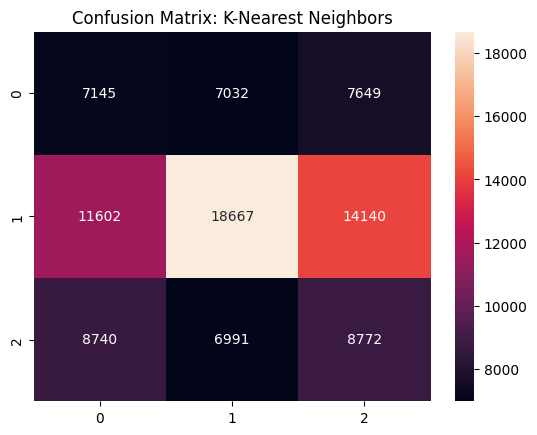

__________________________________
No feature importance or coefficients for K-Nearest Neighbors
____________________________________________
____________________________________________
Processing XGBoost for symbol: SPY
XGBoost - F1 Score: 0.49073588464527207
Confusion Matrix:
 [[ 5844  8481  7501]
 [ 5672 30880  7857]
 [ 6390  9505  8608]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.33      0.27      0.29     21826
           0       0.63      0.70      0.66     44409
           1       0.36      0.35      0.36     24503

    accuracy                           0.50     90738
   macro avg       0.44      0.44      0.44     90738
weighted avg       0.48      0.50      0.49     90738

Best Hyperparameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9}


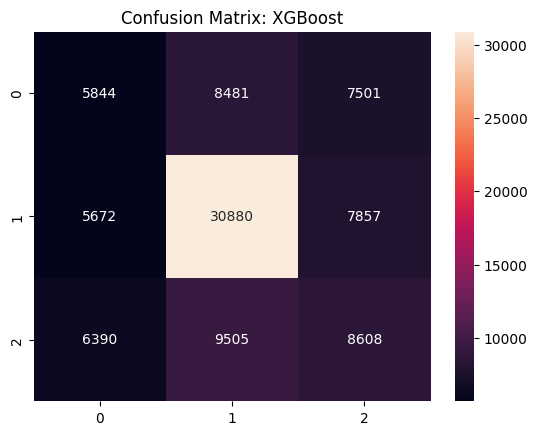

__________________________________
Feature importances for XGBoost:
         feature  importance
26           ATR    0.028361
41      ATR_LAG1    0.024017
65      ATR_LAG4    0.023016
17     MACD_DIFF    0.020354
80    VWAP_LAG10    0.019690
..           ...         ...
87  VOLUME_LAG20    0.003221
5         VOLUME    0.003145
39   VOLUME_LAG1    0.003144
63   VOLUME_LAG4    0.003118
71   VOLUME_LAG5    0.003092

[115 rows x 2 columns]
____________________________________________
____________________________________________
Processing Logistic Regression for symbol: SPY


In [3]:
# Instantiate and use the trading bot
atb = AlpacaTradingBot()

# Select features, target, and symbol to run our classifaction models on 
symbols = ['SPY']
target = 'TARGET_MOVEMENT_SIGNAL'
features = ['CLOSE','HIGH','LOW','TRADE_COUNT','OPEN','VOLUME','VWAP','SMA_15','SMA_30','SMA_120','EMA_15','EMA_30','EMA_120','SMA_15_120_PCT_DIFF','EMA_15_120_PCT_DIFF',
            'MACD','MACD_SIGNAL','MACD_DIFF','ADX','RSI','STOCHASTIC_K','STOCHASTIC_D','CCI','WILLIAMS_R','BOLLINGER_WIDTH_PERCENT','BOLLINGER_POSITION','ATR','OBV',
            'ICHIMOKU_TENKAN_SEN','ICHIMOKU_SENKOU_SPAN_A','ICHIMOKU_SENKOU_SPAN_B','RVI','FORCE_INDEX','AO_IND','RSI_LAG1','MACD_DIFF_LAG1','CCI_LAG1','ADX_LAG1','CLOSE_LAG1',
            'VOLUME_LAG1','VWAP_LAG1','ATR_LAG1','RSI_LAG2','MACD_DIFF_LAG2','CCI_LAG2','ADX_LAG2','CLOSE_LAG2','VOLUME_LAG2','VWAP_LAG2','ATR_LAG2','RSI_LAG3','MACD_DIFF_LAG3','CCI_LAG3',
            'ADX_LAG3','CLOSE_LAG3','VOLUME_LAG3','VWAP_LAG3','ATR_LAG3','RSI_LAG4','MACD_DIFF_LAG4','CCI_LAG4','ADX_LAG4','CLOSE_LAG4','VOLUME_LAG4','VWAP_LAG4','ATR_LAG4','RSI_LAG5',
            'MACD_DIFF_LAG5','CCI_LAG5','ADX_LAG5','CLOSE_LAG5','VOLUME_LAG5','VWAP_LAG5','ATR_LAG5','RSI_LAG10','MACD_DIFF_LAG10','CCI_LAG10','ADX_LAG10','CLOSE_LAG10','VOLUME_LAG10',
            'VWAP_LAG10','ATR_LAG10','RSI_LAG20','MACD_DIFF_LAG20','CCI_LAG20','ADX_LAG20','CLOSE_LAG20','VOLUME_LAG20','VWAP_LAG20','ATR_LAG20','RSI_LAG30','MACD_DIFF_LAG30','CCI_LAG30',
            'ADX_LAG30','CLOSE_LAG30','VOLUME_LAG30','VWAP_LAG30','ATR_LAG30','RSI_SQUARED','CCI_SQUARED','MACD_SQUARED','ADX_SQUARED','BOLLINGER_WIDTH_PERCENT_SQUARED','SMA_30_RSI',
            'MACD_STOCHASTIC_K','EMA_30_ATR','RSI_MACD_DIFF_INTERACTION','SMA_30_ADX_INTERACTION','BOLLINGER_POSITION_ATR_INTERACTION','DAY_OF_WEEK','HOUR_OF_DAY',
            'DAILY_MOVEMENT_SINCE_OPEN','WEEKLY_MOVEMENT_SINCE_OPEN','PCT_MOVEMENT_20_PERIODS','PCT_MOVEMENT_60_PERIODS' ]

# Run models for each symbol
for symbol in symbols:
    print(f"Processing symbol: {symbol}")
    atb.classification_modeling(features, target, symbol)
    print(f"Completed processing for symbol: {symbol}\n")

### Apply Predictions

In [ ]:
"""

Query current day's data, insert to stage, add indicators & add model predictions based on already created models.

"""
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["SPY"]

# Just query current day's data
# start_date = datetime.now().strftime("%Y-%m-%d")
# end_date = datetime.now().strftime("%Y-%m-%d")

# Step 1: Download ticks and add to stage table
# data = {}
# for stock in stocks:
    # Download historical data
    # stock_data = atb.download_bar_data(stock, TimeFrame(1, TimeFrameUnit.Minute), start_date, end_date)
    # data[stock] = stock_data

# Store all downloaded data in the staging table
# for stock, stock_data in data.items():
#     atb.db_append_no_duplicates('STG_SYMBOL_DATA', stock_data)
#     print(f"Stage table updated with data for {stock}")

# Step 2: Transfer data from the staging table to the modeling staging table
for stock in stocks:
    atb.classification_model_predictions('STG_SYMBOL_DATA', stock, "CLASSIFICATION_MODEL_PREDICTIONS")
    print(f"Model predictions for {stock} stored in CLASSIFICATION_MODEL_PREDICTIONS.")